In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import permutation_importance


In [2]:
# Data Cleaning and Processing

# Load data
df = pd.read_csv("library_occupancy_data.csv")
prelim_df = pd.read_csv("prelim_dates_fall2025.csv")  

# Parse calendar fields
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')         
prelim_df['date'] = pd.to_datetime(prelim_df['date'], format='%Y-%m-%d', errors='coerce')

# Time -> decimal hour (e.g., 4:30 PM -> 16.5)
t = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')
df['Hour'] = t.dt.hour + t.dt.minute/60

# Drop rows where essentials failed to parse
df = df.dropna(subset=['Date', 'Time', 'Hour', 'DayOfWeek']).reset_index(drop=True)

# Build prelim-day sets 
pre_dates = prelim_df['date'].dropna().dt.normalize().unique()
pre_set = set(pre_dates)
pre_minus1_set = {d - pd.Timedelta(days=1) for d in pre_set}

# Flag prelim and day-before
df['Date_norm'] = df['Date'].dt.normalize()
df['IsPrelimDay']   = df['Date_norm'].isin(pre_set).astype(int)
df['IsPrelimMinus1'] = df['Date_norm'].isin(pre_minus1_set).astype(int)
df = df.drop(columns=['Date_norm'])

# Day-of-week -> numeric
day_map = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
df['DayOfWeek_num'] = df['DayOfWeek'].map(day_map)

# Sanity checks
print("Rows:", len(df))
print("Prelim flagged:", df['IsPrelimDay'].sum())
print("Day-before flagged:", df['IsPrelimMinus1'].sum())
print(df[['Date','IsPrelimDay','IsPrelimMinus1']].head())


Rows: 80
Prelim flagged: 19
Day-before flagged: 21
        Date  IsPrelimDay  IsPrelimMinus1
0 2025-10-05            0               0
1 2025-10-05            0               0
2 2025-10-05            0               0
3 2025-10-06            0               1
4 2025-10-06            0               1


In [3]:
# Hours helper
def in_range(h, start, end):
    """Return True if hour h is within [start, end) in 24h format."""
    return (h >= start) and (h < end)

# IsClosed per library 
# These are used to determine whether a given 
# library was closed on the day and time collected.

def is_closed_olin(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 24) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 18) else 1
    if d == 'Saturday': return 0 if in_range(h, 10, 18) else 1
    if d == 'Sunday': return 0 if in_range(h, 10, 24) else 1
    return 1

def is_closed_uris(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 23) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 17) else 1
    if d == 'Saturday': return 0 if in_range(h, 12, 17) else 1
    if d == 'Sunday': return 0 if in_range(h, 12, 23) else 1
    return 1

def is_closed_mann(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 22) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 18) else 1
    if d == 'Saturday': return 0 if in_range(h, 12, 18) else 1
    if d == 'Sunday': return 0 if in_range(h, 12, 22) else 1
    return 1

def is_closed_math(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Saturday', 'Sunday']:
        return 1
    return 0 if in_range(h, 9, 16) else 1

df['IsClosed_Olin'] = df.apply(is_closed_olin, axis=1)
df['IsClosed_Uris'] = df.apply(is_closed_uris, axis=1)
df['IsClosed_Mann'] = df.apply(is_closed_mann, axis=1)
df['IsClosed_Math'] = df.apply(is_closed_math, axis=1)

# Drop rows if anything essential failed to parse
req = ['Hour','DayOfWeek_num','IsClosed_Olin','IsClosed_Uris',
       'IsClosed_Mann','IsClosed_Math']
df = df.dropna(subset=req).reset_index(drop=True)



,Library,RF R² (Baseline: Hour+DoW),RF R² (IsClosed+Prelim)
0,Olin,0.297,0.481
1,Uris,-0.037,0.132
2,Mann,0.244,0.373
3,Math,0.642,0.721


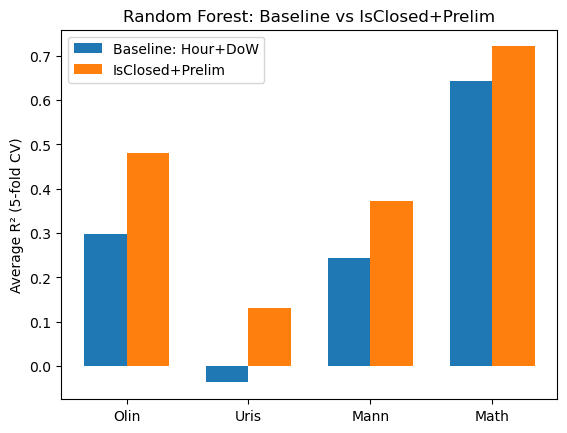

In [4]:
# Same CV for both models (Random Forest)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

libraries = ['Olin','Uris','Mann','Math']
for lib in libraries:
    # Baseline features
    X_base = df[['Hour','DayOfWeek_num']]

    # "With" features (Adding closing hours, and whether the data 
    # point falls on a prelim day, or a day before a prelim)
    X_with = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]

    y = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    rf_base = cross_val_score(rf, X_base, y, scoring='r2', cv=cv).mean()
    rf_with = cross_val_score(rf, X_with, y, scoring='r2', cv=cv).mean()

    results.append({
        'Library': lib,
        'RF R² (Baseline: Hour+DoW)': rf_base,
        'RF R² (IsClosed+Prelim)': rf_with
    })

compare_df = pd.DataFrame(results).round(3)
display(compare_df)

# Plot 
plt.figure()
w = 0.35
x = np.arange(len(compare_df))
plt.bar(x - w/2, compare_df['RF R² (Baseline: Hour+DoW)'], width=w, label='Baseline: Hour+DoW')
plt.bar(x + w/2, compare_df['RF R² (IsClosed+Prelim)'], width=w, label='IsClosed+Prelim')
plt.xticks(x, compare_df['Library'])
plt.ylabel('Average R² (5-fold CV)')
plt.title('Random Forest: Baseline vs IsClosed+Prelim')
plt.legend()
plt.show()


In [5]:
# MAE via Cross Validation (Random Forest)

mae_rows = []
for lib in libraries:
    X_lib = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y_lib = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    maes = []
    for train_idx, test_idx in cv.split(X_lib):
        rf.fit(X_lib.iloc[train_idx], y_lib.iloc[train_idx])
        preds = rf.predict(X_lib.iloc[test_idx])
        maes.append(mean_absolute_error(y_lib.iloc[test_idx], preds))

    mae_rows.append({'Library': lib, 'RF MAE (with added features)': np.mean(maes)})

mae_df = pd.DataFrame(mae_rows).round(2)
mae_df

,Library,RF MAE (with added features)
0,Olin,117.06
1,Uris,77.30
2,Mann,65.20
3,Math,29.53


In [6]:
# Date-based Cross-Validation (GroupKFold by calendar day)
#
# Regular K-Fold mixes rows from the same day into both train/test,
# which makes the task easier (the model sees very similar contexts).
# GroupKFold holds out *entire days* at a time. This better tests
# generalization to unseen days.
#
# - RF performance usually drops under Date-CV (harder problem).
# - This shows we’re good hour-to-hour within a day but we still struggle on unseen days.

gcv = GroupKFold(n_splits=5)
groups = df['Date'].dt.normalize()  # group by whole calendar day

def cv_r2_table(group_cv, groups):
    rows = []
    for lib in libraries:
        # Features: hour, DOW, is-closed, prelim day, day-before
        X = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
        y = df[lib]

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_scores = cross_val_score(rf, X, y, scoring='r2', cv=group_cv, groups=groups)

        rows.append({
            'Library': lib,
            'RF R² (Date-CV, IsClosed+Prelim)': rf_scores.mean()
        })
    return pd.DataFrame(rows).round(3)

# Sanity check: need at least 5 unique days
# print("Unique days:", groups.nunique())

results_datecv_df = cv_r2_table(gcv, groups)
display(results_datecv_df)


,Library,"RF R² (Date-CV, IsClosed+Prelim)"
0,Olin,-0.444
1,Uris,-0.226
2,Mann,-0.028
3,Math,0.481


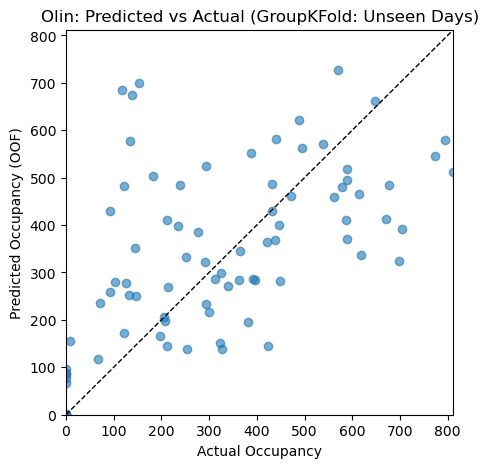

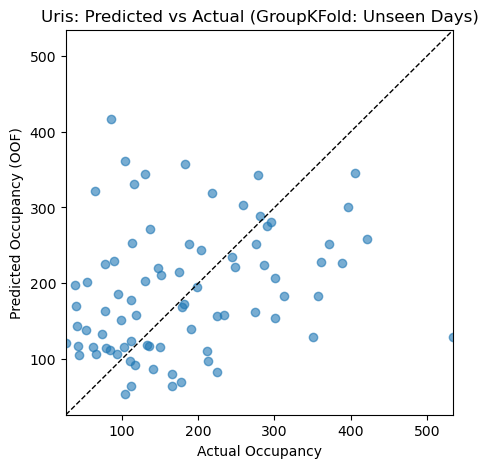

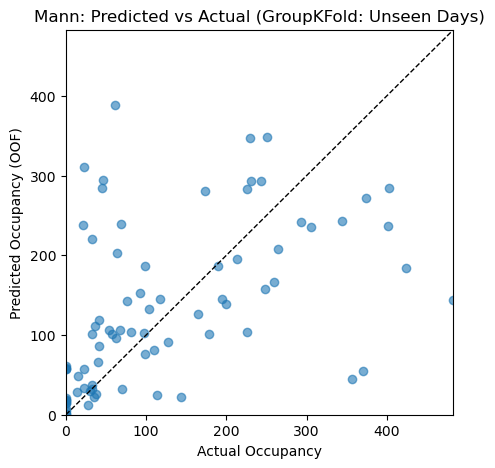

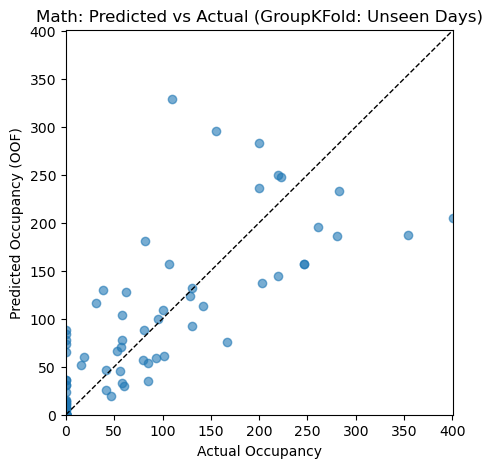

In [7]:
# Predicted vs Actual (Date-Based CV / GroupKFold)
# This shows how well the model generalizes to *unseen days*,
# meaning it tests the model's ability to predict when it has
# NOT seen any data from that date before.


for lib in libraries:
    # Features used in the model
    X = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]
    
    # Model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Out-of-fold predictions (each prediction is made from a model that has NOT seen that day)
    y_pred_oof = cross_val_predict(rf, X, y, cv=gcv, groups=groups)

    # Plot Actual vs Predicted
    plt.figure(figsize=(5,5))
    plt.scatter(y, y_pred_oof, alpha=0.6)
    
    # 45° reference line (perfect predictions)
    lims = [min(y.min(), y_pred_oof.min()), max(y.max(), y_pred_oof.max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlim(lims); plt.ylim(lims)
    
    plt.xlabel("Actual Occupancy")
    plt.ylabel("Predicted Occupancy (OOF)")
    plt.title(f"{lib}: Predicted vs Actual (GroupKFold: Unseen Days)")
    plt.show()



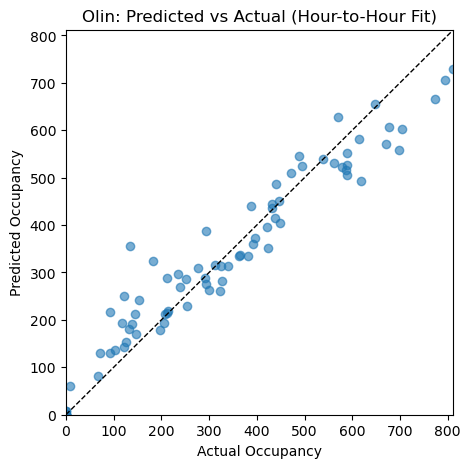

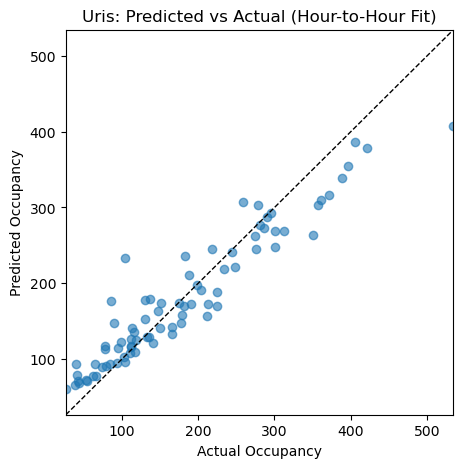

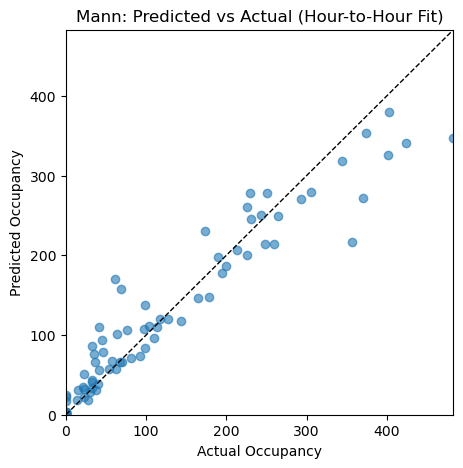

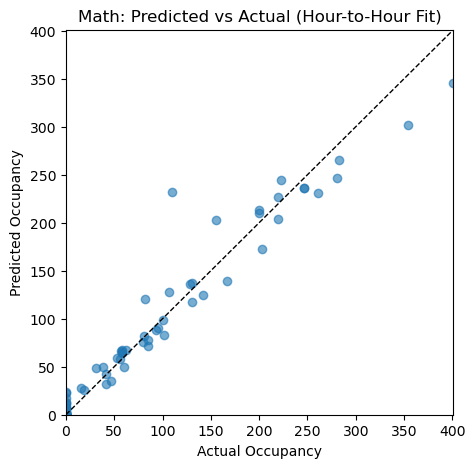

In [8]:
# Predicted vs Actual (Hour-to-Hour Fit on Training Data)
# This shows how well the model matches *patterns observed
# within the same days it was trained on*. This is NOT a
# generalization test — it reflects how closely the model
# learns the typical daily occupancy curve.
# Useful for understanding whether the model captures
# intraday shape (rush hours, slow periods, etc.).

for lib in libraries:

    # Features used in the hour-level model
    X = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    preds = rf.predict(X)

    # Plot 
    plt.figure(figsize=(5,5))
    plt.scatter(y, preds, alpha=0.6)

    # 45° line 
    lims = [min(y.min(), preds.min()), max(y.max(), preds.max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlim(lims); plt.ylim(lims)

    plt.xlabel("Actual Occupancy")
    plt.ylabel("Predicted Occupancy")
    plt.title(f"{lib}: Predicted vs Actual (Hour-to-Hour Fit)")
    plt.show()


In [9]:

# Feature Importance (Random Forest)
# This shows which features contribute most to the model's
# occupancy predictions. 
# This helps us identify what the model is actually *using*:
# - Hour + DayOfWeek should dominate (daily usage pattern)
# - IsClosed should matter heavily when libraries are closed
# - Prelim features may impact spikes (but limited dataset)

for lib in libraries:

    # Feature set for this library
    X = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]

    # Train Random Forest for feature importance extraction
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Create sorted importance table
    importance = (
        pd.Series(rf.feature_importances_, index=X.columns)
        .sort_values(ascending=False)
        .rename("Importance")
        .round(3)
    )

    print(f"Feature Importance for {lib} Library:")
    display(importance.to_frame())  # cleaner table format



Feature Importance for Olin Library:


,Importance
Hour,0.553
DayOfWeek_num,0.269
IsClosed_Olin,0.102
IsPrelimMinus1,0.040
IsPrelimDay,0.036


Feature Importance for Uris Library:


,Importance
Hour,0.753
DayOfWeek_num,0.120
IsPrelimMinus1,0.069
IsClosed_Uris,0.032
IsPrelimDay,0.026


Feature Importance for Mann Library:


,Importance
Hour,0.706
IsClosed_Mann,0.122
DayOfWeek_num,0.072
IsPrelimMinus1,0.059
IsPrelimDay,0.042


Feature Importance for Math Library:


,Importance
Hour,0.713
DayOfWeek_num,0.198
IsClosed_Math,0.059
IsPrelimMinus1,0.020
IsPrelimDay,0.009


In [10]:
# Comparison + MAE summary
results_df = pd.DataFrame(results)

mae_df_fixed = mae_df.rename(columns={
    'RF MAE (with added features)': 'RF MAE'
})

summary_df = (
    results_df.merge(mae_df_fixed, on='Library', how='inner')
              [['Library',
                'RF R² (Baseline: Hour+DoW)',
                'RF R² (IsClosed+Prelim)',
                'RF MAE']]
              .round(3)
)

display(summary_df)

,Library,RF R² (Baseline: Hour+DoW),RF R² (IsClosed+Prelim),RF MAE
0,Olin,0.297,0.481,117.06
1,Uris,-0.037,0.132,77.30
2,Mann,0.244,0.373,65.20
3,Math,0.642,0.721,29.53


In [11]:
# Permutation Importance (Evaluated on Unseen Days)
# This tells us which features matter *when predicting a new day we haven't seen before*.

for lib in libraries:
    # Features used in the model
    X = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train only on some days, test on the held-out days (no leakage)
    train_idx, test_idx = next(gcv.split(X, y, groups=groups))
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])

    # Measure how much each feature changes model performance when shuffled
    perm = permutation_importance(
        rf, X.iloc[test_idx], y.iloc[test_idx],
        n_repeats=20, random_state=42
    )

    importance = (
        pd.Series(perm.importances_mean, index=X.columns)
        .sort_values(ascending=False)
        .round(3)
    )

    print(f"\nPermutation Importance (Unseen Days) — {lib}")
    display(importance.to_frame(name="Importance"))



Permutation Importance (Unseen Days) — Olin


,Importance
Hour,0.312
IsPrelimMinus1,0.221
IsClosed_Olin,0.124
DayOfWeek_num,0.118
IsPrelimDay,0.000



Permutation Importance (Unseen Days) — Uris


,Importance
Hour,0.479
IsPrelimMinus1,0.075
IsClosed_Uris,0.021
IsPrelimDay,0.000
DayOfWeek_num,-0.313



Permutation Importance (Unseen Days) — Mann


,Importance
Hour,0.269
IsPrelimMinus1,0.089
IsClosed_Mann,0.067
DayOfWeek_num,0.017
IsPrelimDay,0.000



Permutation Importance (Unseen Days) — Math


,Importance
Hour,1.351
DayOfWeek_num,0.391
IsClosed_Math,0.158
IsPrelimMinus1,0.132
IsPrelimDay,0.000
